In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

c:\Users\ezece\anaconda3\envs\FBRest_Net\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create model

In [2]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 1,
    'r' : 1

}

In [3]:
# Model
model = FBRestNet(
    experimentation=Physics(params['N'],params['k'],params['a'],params['r']), constraint = 'cube', nb_blocks=20, noise = 0.005,
    folder = './../', im_set="Set1",batch_size=[600,1],lr=1e-3, nb_epochs=[30,1]
)

In [7]:
# Generate dataset
train_set, val_set = model.CreateDataSet(save='no')

## Prepare signal

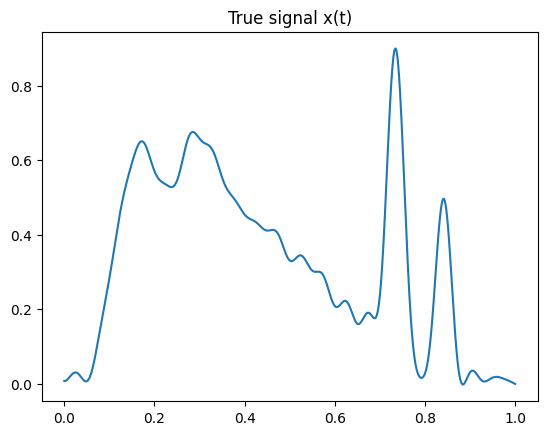

In [8]:
# Select one signal
signal_id = 6
[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

# Prepare start value
x_init   = torch.zeros(x_bias.size())
inv      = np.diag(model.physics.eigm**(2*model.physics.a))
tTTinv   = MyMatmul(inv)
x_init   = tTTinv(y) # no filtration of high frequences
x_init   = Variable(x_init,requires_grad=False)


t = np.linspace(0,(params['N']-1)/params['N'],params['N'])
plt.plot(t, model.model.Layers[0].Pelt(x_true).numpy()[0,0])
plt.title('True signal x(t)')
plt.show()

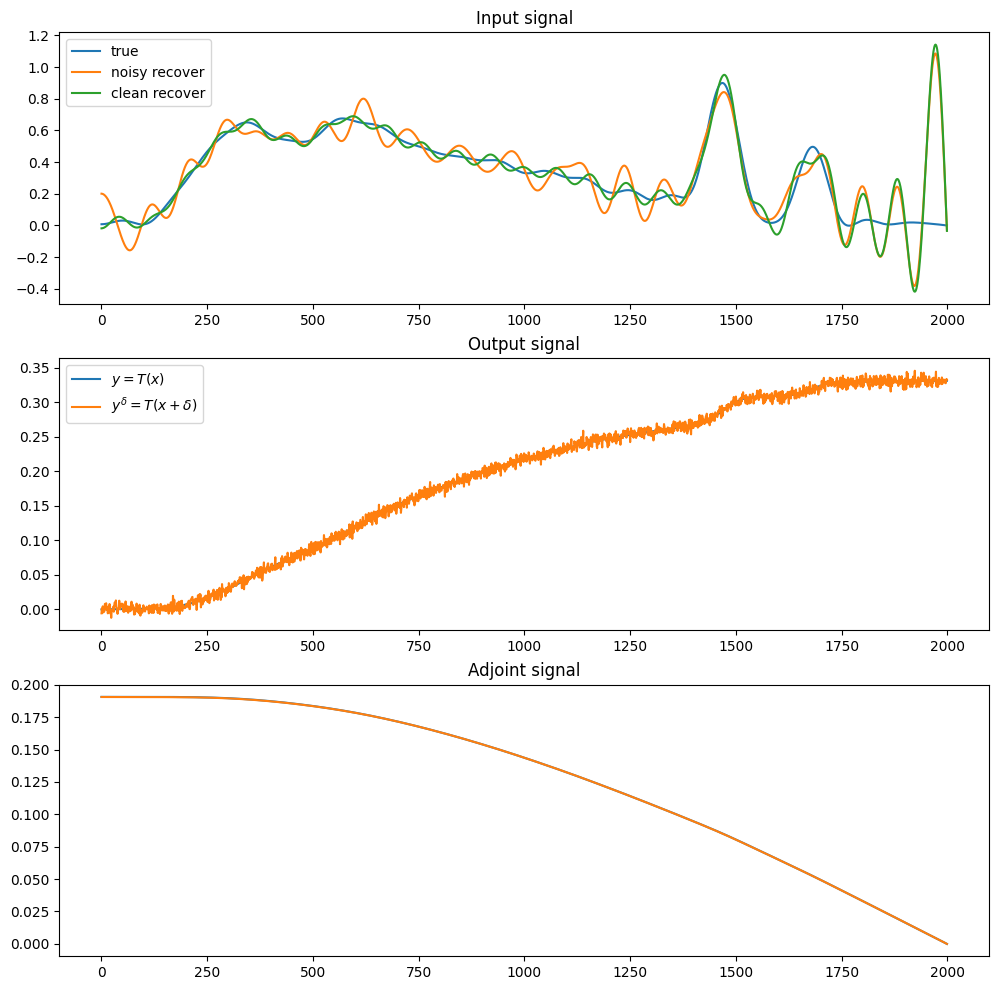

In [39]:
test_signal_coeff = np.random.rand(params['k']) - 0.5 #; test_signal_coeff[0:22:3] = 1/6
test_signal_coeff /= sum(test_signal_coeff**2)
test_signal_coeff = np.array(x_true[0,0])
test_signal_elt = torch.Tensor(model.physics.basis.T @ test_signal_coeff * params['N'])

y =  model.physics.Compute(test_signal_elt)
y_noisy = model.physics.Compute(test_signal_elt) + torch.randn(test_signal_elt.shape) * 0.005
y_noisy_adj = model.physics.BasisChangeInv(model.physics.ComputeAdjoint(y_noisy))
y_adj = model.physics.BasisChangeInv(model.physics.ComputeAdjoint(y))

# T*T inverse
inv      = np.diag(model.physics.eigm**(2*model.physics.a))
tTTinv   = MyMatmul(inv)
x_hat_noisy   = tTTinv(torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y_noisy))))
x_hat   = tTTinv(torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y))))

im, ax = plt.subplots(3,1, figsize=(12,12))
ax[0].plot(test_signal_elt, label='true')
ax[0].plot(model.physics.BasisChangeInv(x_hat_noisy), label='noisy recover')
ax[0].plot(model.physics.BasisChangeInv(x_hat), label='clean recover')
ax[0].legend()
ax[0].set_title('Input signal')

ax[1].plot(y, label='$y=T(x)$')
ax[1].plot(y_noisy, label='$y^{\delta}=T(x+\delta)$')
ax[1].legend()
ax[1].set_title('Output signal')

ax[2].plot(y_adj)
ax[2].plot(y_noisy_adj)
ax[2].set_title('Adjoint signal')
plt.show()

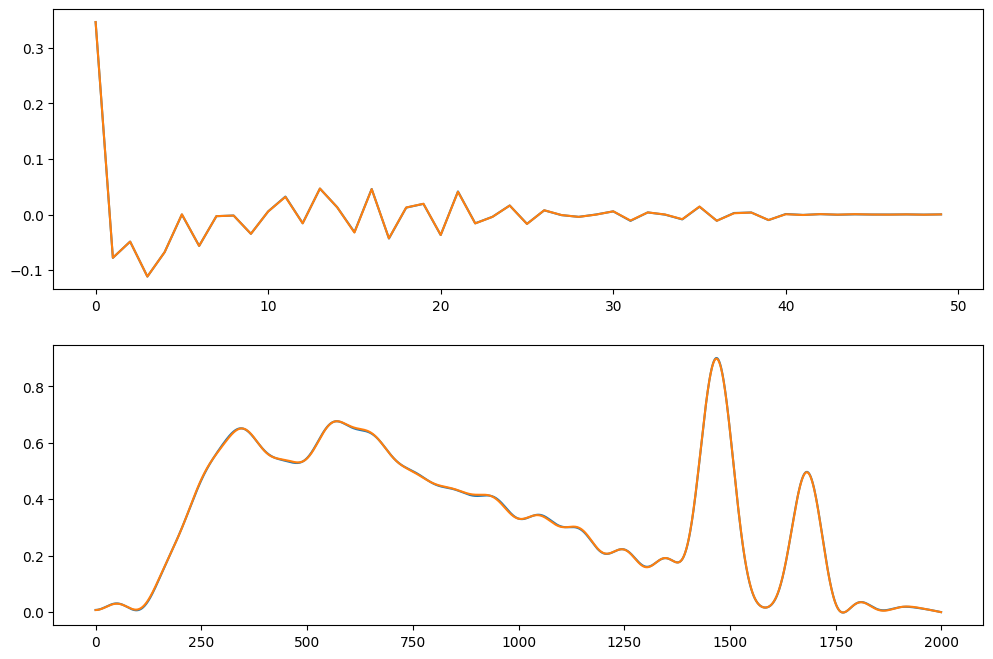

In [10]:
test_signal_eig = model.physics.BasisChange(test_signal_elt)
test_signal_eig_noisy = model.physics.BasisChange(test_signal_elt_noisy)
test_signal_elt_recover = model.physics.BasisChangeInv(test_signal_eig)
test_signal_elt_noisy_recover = model.physics.BasisChangeInv(test_signal_eig_noisy)

fig,ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(test_signal_eig)
ax[0].plot(test_signal_eig_noisy)

ax[1].plot(test_signal_elt_recover)
ax[1].plot(test_signal_elt_noisy_recover)
plt.show()